# Compare occupations by work activities

Occupation similarity in terms of work activities was captured using the recently released official [ESCO skills
hierarchy](https://ec.europa.eu/esco/portal/news/c7a26e8f-fe83-4d48-ba09-bf97e1c7c78b). This hierarchy specifies a categorisation of skills at three levels, where the categories at the lowest level are based on the intermediate work activities of O\*NET (find more information [here](https://ec.europa.eu/esco/portal/escopedia/Skills_pillar)). Skills in the same category can, therefore, be seen as pertaining to the same type of work activity.

To estimate the extent to which occupations share a similar profile of work activities, we constructed a feature vector with its elements representing the relative intensity of each type of activity and compared the alignment of these vectors across all ESCO occupations.

Note that here we calculate distances between all 2942 ESCO occupations, whereas in the Mapping Career Causeways report we focus on a subset of transitions pertaining to the "top level" 1627 ESCO occupations (for more information, see report's Appendix).

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble.ipy

from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform

In [2]:
# ESCO occupations
occupations = pd.read_csv(f'{data_folder}processed/ESCO_occupations.csv')

# ESCO skills
skills = pd.read_csv(f'{data_folder}processed/ESCO_skills_hierarchy/ESCO_skills_hierarchy.csv')
concepts = pd.read_csv(f'{data_folder}processed/ESCO_skills_hierarchy/ESCO_skills_concepts_hierarchy.csv')
occupation_to_skills = pd.read_csv(f'{data_folder}processed/ESCO_occupation_to_skills.csv')

# Import dataframe with essential skills id for each occupation
node_to_essential_items = pickle.load(open(f'{data_folder}processed/occupation_to_essential_skills.pickle','rb'))
 
# Import essential and optional skills similarity matrices, to compare with the work activity similarities
W_essential = np.load(f'{data_folder}processed/sim_matrices/occupationSimilarity_EssentialSkillsDescription_asymmetric.npy')
W_all_to_essential = np.load(f'{data_folder}processed/sim_matrices/occupationSimilarity_AllToEssentialSkillsDescription_asymmetric.npy')


In [3]:
# Folder where the final similarity matrix will be stored
output_folder = f'{data_folder}processed/sim_matrices/'

In [4]:
node_to_essential_items.head(3)

,id,occupation,items_list,sector
0,0,technical director,"[255, 2077, 3803, 4740, 7121, 7863, 12954, 13418]",2
1,1,metal drawing machine operator,"[2156, 2687, 2756, 2888, 3154, 3698, 3722, 564...",8
2,2,precision device inspector,"[910, 1280, 1996, 2586, 2589, 2756, 3490, 5574...",7


# 1. Work activity vectors for each ESCO occupation

For each occupation, we constructed a work activity feature vector with 75 elements where each element
corresponds to a particular category from the second level of the ESCO skills hierarchy. The value of each element was set to the number of occurrences of its corresponding skill category in the occupation’s **essential** skills set.  For our purposes, we only counted essential skills that, moreover, were indeed designated as ‘skills’ items by the ESCO skills pillar categories (as opposed to ‘knowledge’, ‘attitudes’ or ‘values’ items)

In [5]:
def get_occupation_vectors(level, normalise=True):
    """
    Parameters
    ----------
    level (int):
        Which level of hierarchy to use (can be 1, 2 or 3)
    normalise (boolean):
        If True, the function will return unit vectors (for occupation comparison, we use True)
        
    Returns
    -------
    occupation_vectors (nd.array):
        N x M vector, where N corresponds to the number of occupations and M corresponds
        to the number of categories (elements in the vector)
    
    """
    
    df_level_concepts = concepts[concepts.hierarchy_level==level]
    # NB: We're using only skills (not knowledge or attitudes)
    df_level_concepts = df_level_concepts[df_level_concepts.code.str.contains('S')]
    df_level_concepts = df_level_concepts.sort_values('code')
    vector_dict = dict(zip(df_level_concepts.code.to_list(), range(len(df_level_concepts))))

    # Create occupation vectors
    occupation_vectors = np.zeros((len(occupations),len(vector_dict.keys())))

    for i in range(len(occupations)):
        # NB: We're using the essential skills
        x_list = skills.loc[node_to_essential_items.items_list.loc[i]]['level_'+str(level)].to_list()
        for x in x_list:
            if x in vector_dict.keys():
                occupation_vectors[i, vector_dict[x]] = occupation_vectors[i, vector_dict[x]] + 1
    
    if normalise==True:
        # Normalise the vectors
        occupation_vectors_norm = np.zeros(occupation_vectors.shape)

        for i in range(occupation_vectors_norm.shape[0]):
            occupation_vectors_norm[i,:] = normalize(occupation_vectors[i,:].reshape(1,-1))        
        
        occupation_vectors = occupation_vectors_norm

    return occupation_vectors, df_level_concepts['code'].to_list()


In [6]:
# Create cluster intensity vectors for all levels of ESCO skills hierarchy (we'll use the second level)
occupation_vectors_level_1, element_codes_1 = get_occupation_vectors(level=1, normalise=True)
occupation_vectors_level_2, element_codes_2 = get_occupation_vectors(level=2, normalise=True)
occupation_vectors_level_3, element_codes_3 = get_occupation_vectors(level=3, normalise=True)

occupation_vectors_level_1_abs, _ = get_occupation_vectors(level=1, normalise=False)
occupation_vectors_level_2_abs, _ = get_occupation_vectors(level=2, normalise=False)
occupation_vectors_level_3_abs, _ = get_occupation_vectors(level=3, normalise=False)

In [7]:
# Second level has 75 categories
occupation_vectors_level_2.shape

(2942, 75)

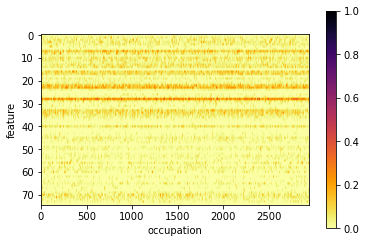

In [8]:
# Plot cluster intensity vectors
plt.imshow(occupation_vectors_level_2.T, aspect=25, cmap='inferno_r')
plt.colorbar()
plt.xlabel('occupation')
plt.ylabel('feature')
plt.show()

In [9]:
# Note the most categories that are on average the most intense
x = np.array(element_codes_2)[np.argsort(np.mean(occupation_vectors_level_2,0))]
concepts[concepts.code.isin(x[-10:])][['title','code','number_of_items']]

,title,code,number_of_items
308,liaising and networking,S1.2,253
325,advising and consulting,S1.5,377
361,"conducting studies, investigations and examina...",S2.1,299
366,documenting and recording information,S2.2,279
390,analysing and evaluating information and data,S2.7,358
398,"monitoring, inspecting and testing",S2.8,668
425,protecting and enforcing,S3.3,462
452,developing objectives and strategies,S4.1,353
461,"organising, planning and scheduling work and a...",S4.2,425
481,supervising people,S4.8,162


# 2. Calculate similarities of work activity feature vectors

In [10]:
# Euclidean distances
d_esco_level_3 = squareform(pdist(occupation_vectors_level_3, metric='euclidean'))
d_esco_level_2 = squareform(pdist(occupation_vectors_level_2, metric='euclidean'))

# Similarities (normalise between 0 and 1)
d_esco_level_2_norm = (d_esco_level_2-np.min(d_esco_level_2))/(np.max(d_esco_level_2)-np.min(d_esco_level_2))
d_esco_level_3_norm = (d_esco_level_3-np.min(d_esco_level_3))/(np.max(d_esco_level_3)-np.min(d_esco_level_3))

W_esco_level_2 = 1 - d_esco_level_2_norm
W_esco_level_3 = 1 - d_esco_level_3_norm

# Save the normalisation parameters (useful for re-calculating the similarities)
d_MIN_LEVEL2 = np.min(d_esco_level_2)
d_MAX_LEVEL2 = np.max(d_esco_level_2)
d_MIN_LEVEL3 = np.min(d_esco_level_3)
d_MAX_LEVEL3 = np.max(d_esco_level_3)
normalisation_params = {
    'd_MIN_LEVEL2': d_MIN_LEVEL2,
    'd_MAX_LEVEL2': d_MAX_LEVEL2,
    'd_MIN_LEVEL3': d_MIN_LEVEL3,
    'd_MAX_LEVEL3': d_MAX_LEVEL3
}

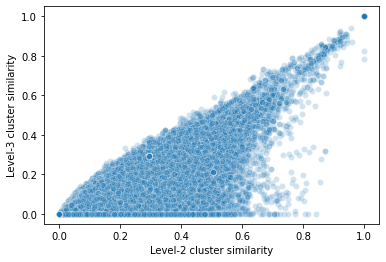

In [11]:
# Check the relationship between Level-2 and Level-3 cluster-based distances
random_sample = np.random.permutation(len(d_esco_level_2.flatten()))[1:400000]
sns.scatterplot(W_esco_level_2.flatten()[random_sample],
                W_esco_level_3.flatten()[random_sample],
                alpha=0.2)
plt.xlabel('Level-2 cluster similarity')
plt.ylabel('Level-3 cluster similarity')
plt.show()

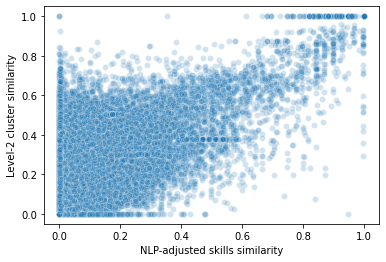

In [12]:
# Check the relationship between Level-2 cluster-based distances and NLP-adjusted overlap of skills
sns.scatterplot(W_essential.flatten()[random_sample],
                W_esco_level_2.flatten()[random_sample],
                alpha=0.2)
plt.xlabel('NLP-adjusted skills similarity')
plt.ylabel('Level-2 cluster similarity')
plt.show()

## 2.1 Check examples

In [13]:
find_closest(None, W_esco_level_2, occupations[['id', 'preferred_label']]).head(10)

,id,preferred_label,similarity
201,201,chef,1.000000
1711,1711,pastry chef,0.760854
1852,1852,diet cook,0.650021
1895,1895,pizzaiolo,0.637507
2198,2198,fish cook,0.634458
2213,2213,grill cook,0.622178
1724,1724,cook,0.611252
1923,1923,private chef,0.522238
2637,2637,cocktail bartender,0.465617
866,866,sommelier,0.465617


# 3. Compare the approach with using cosine similarity

In [14]:
# Cosine distances
D_cos = squareform(pdist(occupation_vectors_level_2, metric='cosine'))
D_cos[np.isnan(D_cos)]=1
W_cos = 1 - D_cos

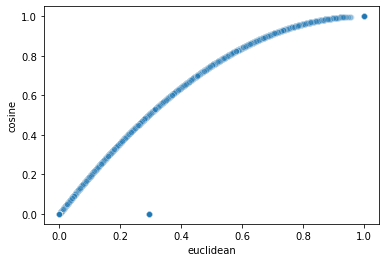

In [15]:
random_sample = np.random.permutation(len(d_esco_level_2.flatten()))[1:400000]
sns.scatterplot(W_esco_level_2.flatten()[random_sample],
                W_cos.flatten()[random_sample],
                alpha=0.2)
plt.xlabel('euclidean')
plt.ylabel('cosine')
plt.show()

# 4. Export the similarity matrices

## 4.1 Similarity matrices

In [16]:
np.save(f'{output_folder}occupationSimilarity_ESCO_clusters_Level_3.npy', W_esco_level_3)
np.save(f'{output_folder}occupationSimilarity_ESCO_clusters_Level_2.npy', W_esco_level_2)


## 4.2 Work activity vectors and codes corresponding to the vector elements/features

In [17]:
feature_folder = f'{data_folder}interim/work_activity_features/'

# Normalised vectors
np.save(feature_folder + 'esco_hierarchy_vectors_level_1.npy', occupation_vectors_level_1)
# Non-normalised vectors
np.save(feature_folder + 'esco_hierarchy_vectors_level_1_abs.npy', occupation_vectors_level_1_abs)
# Skill category codes corresponding to the feature vector elements
pickle.dump(element_codes_1, open(feature_folder + 'esco_hierarchy_codes_level_1.pickle', 'wb'))

np.save(feature_folder + 'esco_hierarchy_vectors_level_2.npy', occupation_vectors_level_2)
np.save(feature_folder + 'esco_hierarchy_vectors_level_2_abs.npy', occupation_vectors_level_2_abs)
pickle.dump(element_codes_2, open(feature_folder + 'esco_hierarchy_codes_level_2.pickle', 'wb'))

np.save(feature_folder + 'esco_hierarchy_vectors_level_3.npy', occupation_vectors_level_3)
np.save(feature_folder + 'esco_hierarchy_vectors_level_3_abs.npy', occupation_vectors_level_3_abs)
pickle.dump(element_codes_3, open(feature_folder + 'esco_hierarchy_codes_level_3.pickle', 'wb'))


In [33]:
# Create a dataframe describing the elements of the work activity feature vector
df = concepts[concepts.code.isin(element_codes_2)][['code', 'title', 'description_en', 'uri']]
df['vector_element'] = list(range(len(df)))
df = df[['vector_element', 'title', 'description_en', 'code', 'uri']]
df.to_csv(f'{data_folder}processed/work_activity_vector_features_Level2.csv', index=False)


## 4.3 Similarity value normalisation parameters

We use this later on, when we make changes to occupation's skillset and recalculate similarities, as part of the 'simulating' upskilling.

In [18]:
pickle.dump(normalisation_params, open(feature_folder + 'esco_hierarchy_norm_params.pickle', 'wb'))